In [1]:
import pandas as pd
import os
import pytz

In [2]:
import numpy as np
import seaborn as sns
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

sns.set()

# 그래프 기본 설정
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 실제 TTF 파일 경로 (예: 나눔고딕)
font_path = '/content/drive/MyDrive/NanumFontSetup_TTF_ALL/NanumGothic.ttf'

# 폰트 등록 및 적용
font_name = fm.FontProperties(fname=font_path).get_name()
fm.fontManager.addfont(font_path)
mpl.rc('font', family=font_name)

In [7]:
df = pd.read_parquet('/content/drive/MyDrive/data/multi_buyers_all_events.parquet')

In [8]:
df

,event_type,product_id,category_id,brand,price,user_id,user_session,event_date,event_hour,category_lvl1,category_lvl2,category_lvl3,category_lvl4,weekday
0,view,1004739,2053013555631882655,xiaomi,197.55,519530528,9882d21f-2c5f-496b-90d4-a1503edb6562,2019-10-01,5,electronics,smartphone,None,None,Tuesday
1,view,1004767,2053013555631882655,samsung,254.82,512558158,9a206ba2-37c7-4354-9d31-37ff3bb297ed,2019-10-01,5,electronics,smartphone,None,None,Tuesday
2,view,1003141,2053013555631882655,apple,382.97,551377651,ca11a570-47da-4630-898b-9a03127703da,2019-10-01,5,electronics,smartphone,None,None,Tuesday
3,view,1005105,2053013555631882655,apple,1415.48,529755884,0b828fb6-99bd-4d26-beb3-3021f5d6102c,2019-10-01,5,electronics,smartphone,None,None,Tuesday
4,view,1004659,2053013555631882655,samsung,787.18,512558158,9a206ba2-37c7-4354-9d31-37ff3bb297ed,2019-10-01,5,electronics,smartphone,None,None,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53878062,view,1401649,2053013563835941749,hp,1588.80,540315194,276ffb89-f24c-4c49-97a6-f0bb2292946b,2020-03-31,23,appliances,kitchen,refrigerators,None,Tuesday
53878063,view,100077607,2232732101063475749,vitek,100.36,633281427,a44da407-c3a0-435b-8c88-bca584ef75c7,2020-03-31,23,appliances,environment,vacuum,None,Tuesday
53878064,view,34900071,2232732087834640627,weber,141.57,519495070,18111012-3d2d-492d-9083-388c683c85a3,2020-03-31,23,appliances,kitchen,grill,None,Tuesday
53878065,view,3100828,2232732091391410500,bosch,102.94,539712971,c7a7720b-8e46-4bb1-9463-fbc36c0840fb,2020-03-31,23,appliances,kitchen,blender,None,Tuesday


In [72]:
# category_lvl3가 결측치인 경우 category_lvl2로 대체
df['category_lvl3'] = df['category_lvl3'].fillna(df['category_lvl2'])

In [73]:
for col in df.columns:
    print(f"Column: {col}")
    print(df[col].unique())
    print("-" * 30)

Column: event_type
['view' 'purchase' 'cart']
------------------------------
Column: product_id
[  1004739   1004767   1003141 ... 100173052 100167132 100165629]
------------------------------
Column: category_id
[2053013555631882655 2053013552326770905 2053013553341792533
 2053013565983425517 2053013554658804075 2053013552293216471
 2053013563810775923 2053013555321504139 2053013553945772349
 2053013555095011711 2053013554415534427 2096280510920655375
 2053013554776244595 2053013556227473861 2053013556202308035
 2090971686529663114 2053013557343158789 2053013563944993659
 2053013554834964853 2053013552351936731 2053013555573162395
 2053013561579406073 2053013566176363511 2053013554751078769
 2053013552570040549 2053013564003713919 2053013566033757167
 2172371436436455782 2098563450757186313 2053013555262783879
 2053013563911439225 2053013555531219353 2053013566100866035
 2053013556252639687 2053013556311359947 2053013552695869677
 2053013563835941749 2053013563743667055 20530135601785

# 분석 목표:
고객 재구매 유도 통한 고객 리텐션 향상

데이터 분석 목표: 1회 구매자 vs 2회 이상 구매자 나누어 분석 후, 재구매 요인 분석과 재구매 유도 방안 도출 (재구매하는 안 하는 이유와 재구매하는 이유 분석)

In [10]:
print(df.columns.tolist())

['event_type', 'product_id', 'category_id', 'brand', 'price', 'user_id', 'user_session', 'event_date', 'event_hour', 'category_lvl1', 'category_lvl2', 'category_lvl3', 'category_lvl4', 'weekday']


# 1. 재구매 요인 분석
각 그룹의 카테고리/상품군 분포 확인
→ 재구매 많은 제품군 파악

재구매율 높은 제품군 특성 분석
→ 예) 반복 소모품인지, 시즌성인지, 생활 밀접인지

In [13]:
# 2. 구매 이벤트만 필터링
purchase_df = df[df['event_type'] == 'purchase']

# 3. 카테고리별 구매 건수 집계 (category_lvl3 기준)
category_counts = purchase_df['category_lvl3'].value_counts().reset_index()
category_counts.columns = ['category_lvl3', 'purchase_count']

# 4. 결과 확인
print(category_counts.head(10))  # 상위 10개만 미리보기

    category_lvl3  purchase_count
0           light         1666074
1       headphone          137998
2        massager          121947
3   refrigerators           90656
4          washer           80779
5          vacuum           79383
6              tv           55303
7  coffee_grinder           37453
8          faucet           36951
9       subwoofer           21339


<Figure size 1200x600 with 0 Axes>

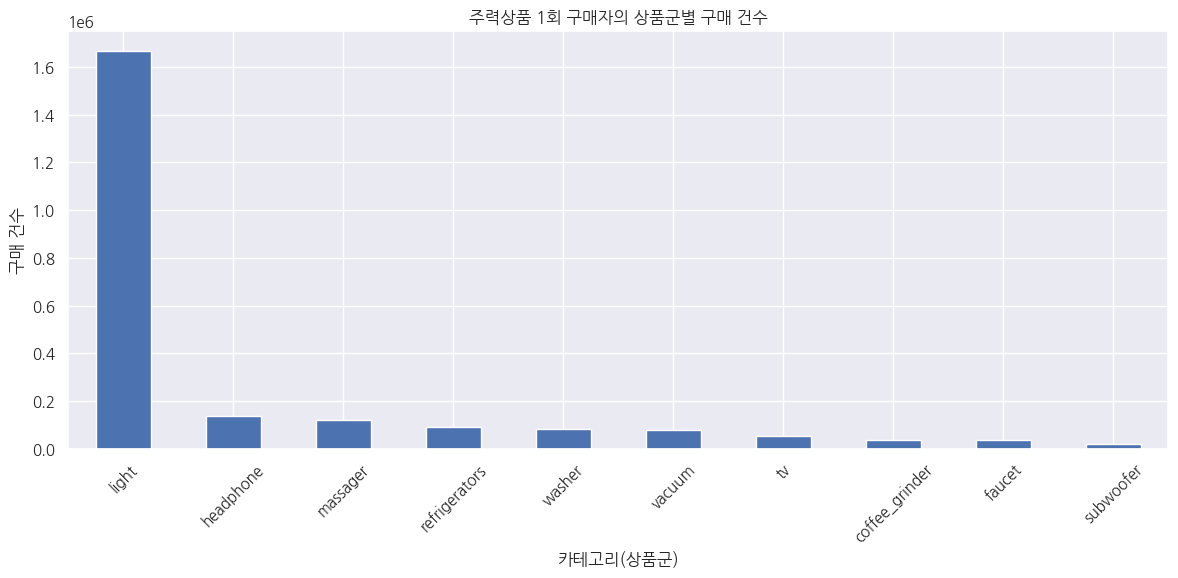

In [14]:
plt.figure(figsize=(12,6))
category_counts.head(10).plot(kind='bar', x='category_lvl3', y='purchase_count', legend=False)
plt.title('주력상품 1회 구매자의 상품군별 구매 건수')
plt.ylabel('구매 건수')
plt.xlabel('카테고리(상품군)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
# 3. 카테고리별 구매 건수 집계 (category_lvl1, 2, 3 기준 그룹)
category_group = purchase_df.groupby(
    ['category_lvl1', 'category_lvl2', 'category_lvl3']
).size().reset_index(name='purchase_count')

# 4. 구매 건수 기준 내림차순 정렬
category_group_sorted = category_group.sort_values(by='purchase_count', ascending=False)

# 5. 상위 10개 결과 확인
print(category_group_sorted.head(10))

   category_lvl1 category_lvl2   category_lvl3  purchase_count
31  construction         tools           light         1666074
39   electronics         audio       headphone          137998
25    appliances      personal        massager          121947
20    appliances       kitchen   refrigerators           90656
23    appliances       kitchen          washer           80779
4     appliances   environment          vacuum           79383
46   electronics         video              tv           55303
7     appliances       kitchen  coffee_grinder           37453
27  construction    components          faucet           36951
42   electronics         audio       subwoofer           21339


/tmp/ipython-input-16-1856729187.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10_categories['full_category'] = (


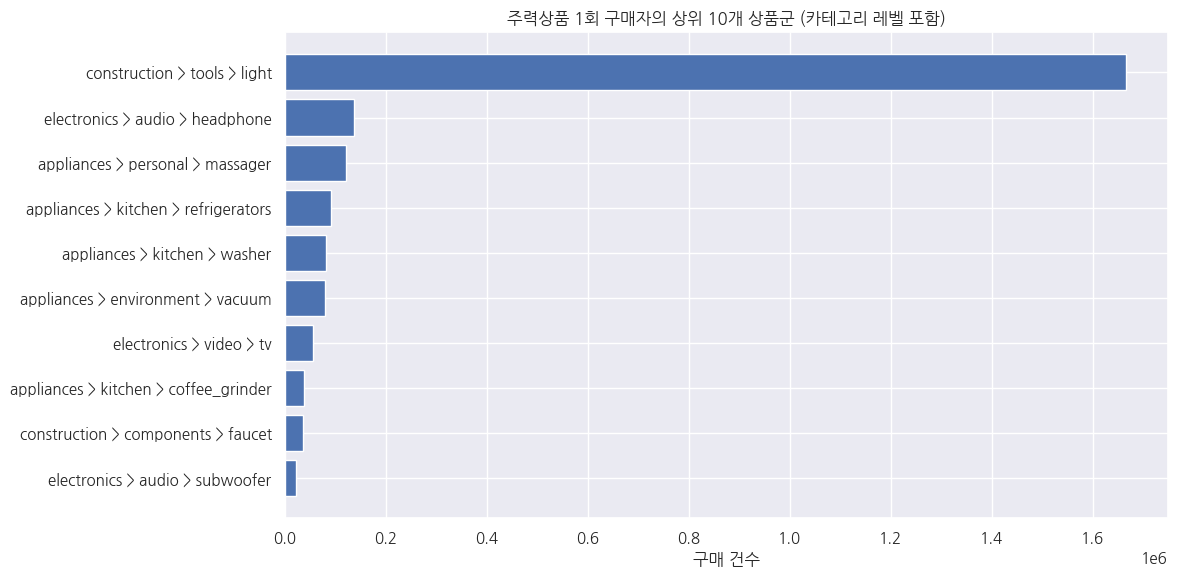

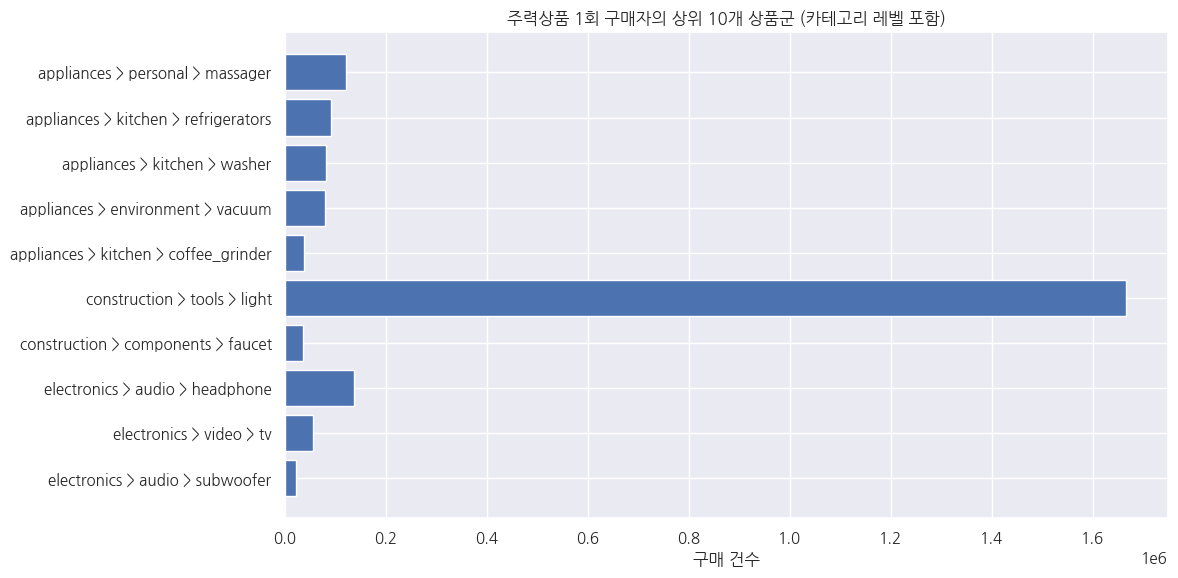

In [16]:
# 시각화용: 상위 10개만 추출
top10_categories = category_group_sorted.head(10)

# 시각화에 사용할 라벨 생성: "level1 > level2 > level3"
top10_categories['full_category'] = (
    top10_categories['category_lvl1'] + ' > ' +
    top10_categories['category_lvl2'] + ' > ' +
    top10_categories['category_lvl3'].fillna('Unknown')
)

# 시각화
plt.figure(figsize=(12, 6))
plt.barh(top10_categories['full_category'], top10_categories['purchase_count'])
plt.xlabel('구매 건수')
plt.title('주력상품 1회 구매자의 상위 10개 상품군 (카테고리 레벨 포함)')
plt.gca().invert_yaxis()  # 가장 높은 값이 위로 오도록 설정
plt.tight_layout()
plt.show()

top10_categories = top10_categories.sort_values(by=['category_lvl1', 'purchase_count'], ascending=[True, False])
# 시각화
plt.figure(figsize=(12, 6))
plt.barh(top10_categories['full_category'], top10_categories['purchase_count'])
plt.xlabel('구매 건수')
plt.title('주력상품 1회 구매자의 상위 10개 상품군 (카테고리 레벨 포함)')
plt.gca().invert_yaxis()  # 가장 높은 값이 위로 오도록 설정
plt.tight_layout()
plt.show()

# 2. 고객 유형 분류
다양한 상품 구매 고객 vs 같은 상품 반복 고객 구분
→ 고객 타입별 리텐션 전략 차별화

제품군이 다양한 고객 vs 집중된 고객 비교
→ 어떤 그룹이 재구매 가능성 높은지 파악

In [17]:
# 구매 데이터만 필터링
purchase_df = df[df['event_type'] == 'purchase']

# 고객별 총 구매 수
user_total_purchases = purchase_df.groupby('user_id')['product_id'].count().reset_index(name='total_purchases')

# 고객별 고유한 product_id 수
user_unique_products = purchase_df.groupby('user_id')['product_id'].nunique().reset_index(name='unique_products')

# 병합
user_profile = pd.merge(user_total_purchases, user_unique_products, on='user_id')

# 고객 유형 분류
def classify_user(row):
    if row['unique_products'] == 1:
        return 'same_product_repeated'
    else:
        return 'various_products'

user_profile['user_type'] = user_profile.apply(classify_user, axis=1)

# 결과 확인
print(user_profile['user_type'].value_counts())

user_type
various_products         505662
same_product_repeated    139536
Name: count, dtype: int64


In [18]:
# user_type 정보 결합
purchase_df = purchase_df.merge(user_profile[['user_id', 'user_type']], on='user_id', how='left')

# 사용자 유형 + 카테고리 기준으로 집계
user_type_cat = purchase_df.groupby(['user_type', 'category_lvl3']).size().reset_index(name='purchase_count')

# 상위 10개씩 확인
print(user_type_cat.sort_values(by='purchase_count', ascending=False).groupby('user_type').head(10))


                user_type   category_lvl3  purchase_count
67       various_products           light         1482437
20  same_product_repeated           light          183637
62       various_products       headphone          122054
68       various_products        massager          109580
79       various_products   refrigerators           82549
90       various_products          washer           72903
88       various_products          vacuum           69646
87       various_products              tv           50989
52       various_products  coffee_grinder           35422
57       various_products          faucet           35098
85       various_products       subwoofer           19891
15  same_product_repeated       headphone           15944
21  same_product_repeated        massager           12367
41  same_product_repeated          vacuum            9737
32  same_product_repeated   refrigerators            8107
43  same_product_repeated          washer            7876
40  same_produ

/tmp/ipython-input-19-2181019986.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_cats = user_type_cat.groupby('user_type').apply(lambda x: x.sort_values(by='purchase_count', ascending=False).head(10)).reset_index(drop=True)


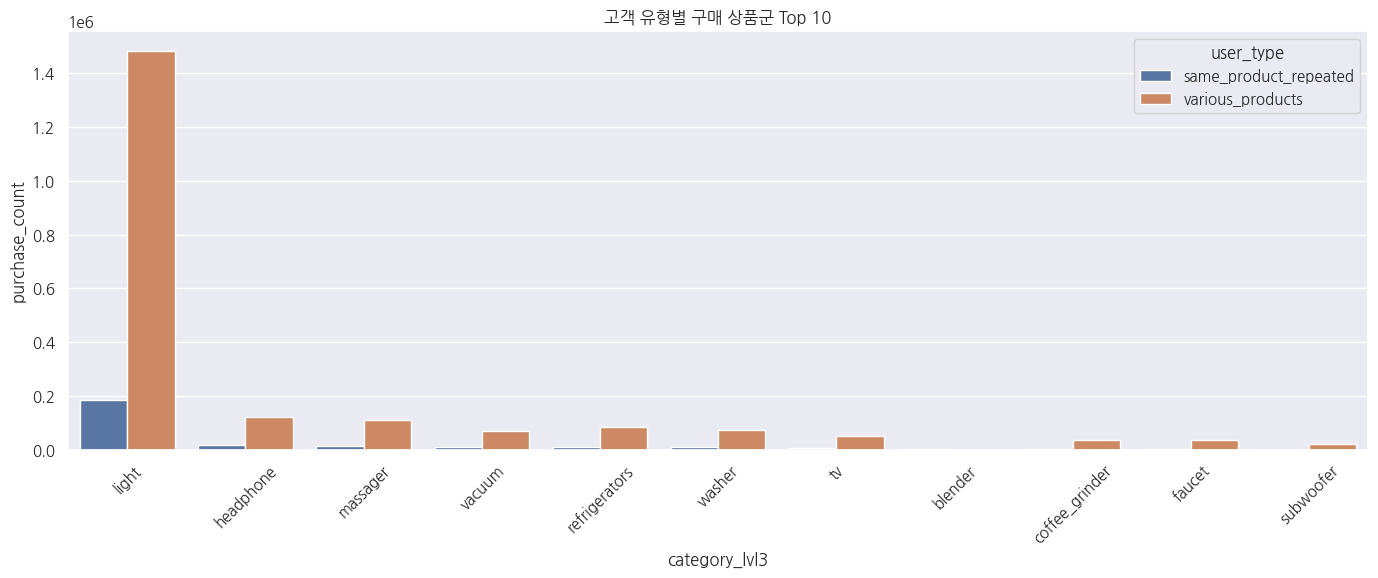

In [19]:
# 상위 10개만 시각화
top_cats = user_type_cat.groupby('user_type').apply(lambda x: x.sort_values(by='purchase_count', ascending=False).head(10)).reset_index(drop=True)

plt.figure(figsize=(14, 6))
sns.barplot(data=top_cats, x='category_lvl3', y='purchase_count', hue='user_type')
plt.title('고객 유형별 구매 상품군 Top 10')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


| 고객유형                    | 반복 구매한 상품군  | 전략 제안                    |
| ----------------------- | ----------- | ------------------------ |
| same\_product\_repeated | 소모품/생활필수품 등 | 재구매 유도, 리마인드 캠페인, 구독 서비스 |
| various\_products       | 카테고리 다양함    | 추천 상품 시스템, 유사 상품 큐레이션    |


In [20]:
# 고객별 전체 구매 건수
user_purchase_count = purchase_df.groupby('user_id')['product_id'].count().reset_index(name='total_purchases')

# 고객별 고유한 상품 수
user_unique_products = purchase_df.groupby('user_id')['product_id'].nunique().reset_index(name='unique_products')

# 병합
user_profile = pd.merge(user_purchase_count, user_unique_products, on='user_id')

# 고객 유형 분류
def classify_user(row):
    if row['unique_products'] == 1:
        return 'same_product_repeated'
    elif row['unique_products'] >= 2:
        return 'various_products'
    else:
        return 'unknown'

user_profile['user_type'] = user_profile.apply(classify_user, axis=1)

# 결과 확인
print(user_profile['user_type'].value_counts())


user_type
various_products         505662
same_product_repeated    139536
Name: count, dtype: int64


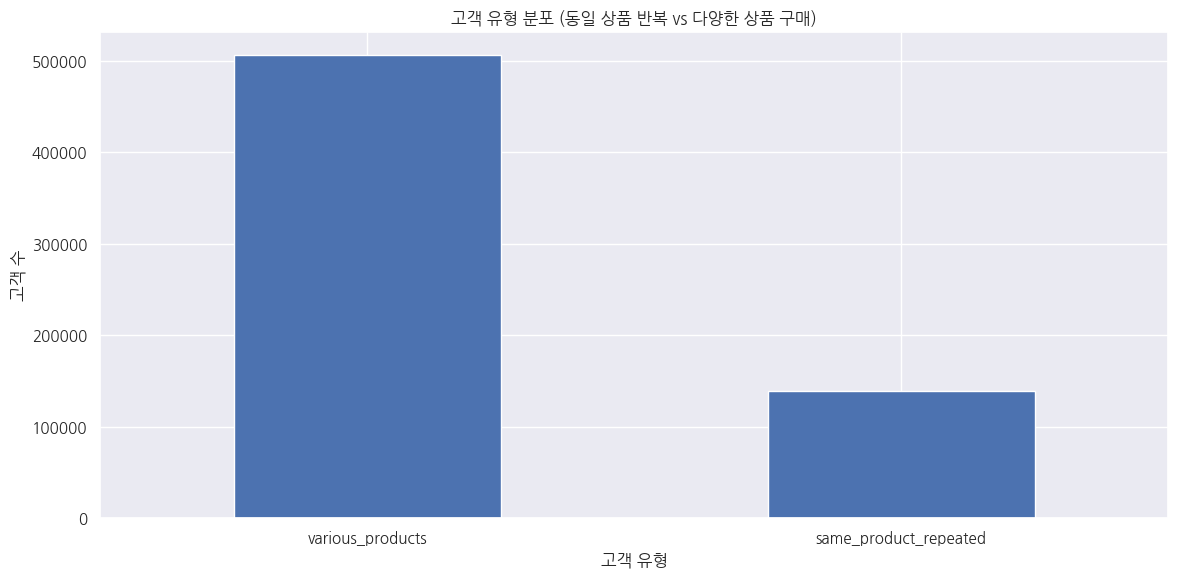

In [21]:
# 고객 유형별 평균 구매 횟수

user_profile['user_type'].value_counts().plot(kind='bar')
plt.title('고객 유형 분포 (동일 상품 반복 vs 다양한 상품 구매)')
plt.ylabel('고객 수')
plt.xlabel('고객 유형')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

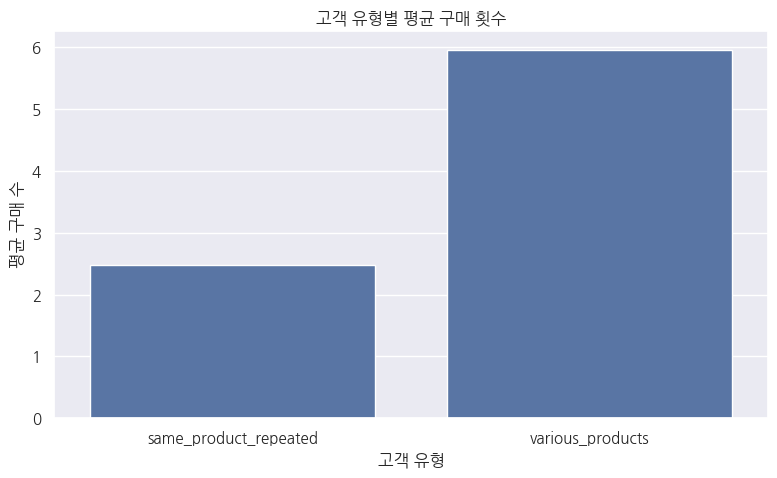

In [78]:
# 고객 유형 분포 (동일 상품 반복 vs 다양한 상품 구매)
# 고객 유형별 평균 총 구매 수 비교
avg_purchase_by_type = user_profile.groupby('user_type')['total_purchases'].mean().reset_index()

# 시각화
plt.figure(figsize=(8, 5))
sns.barplot(data=avg_purchase_by_type, x='user_type', y='total_purchases')
plt.title('고객 유형별 평균 구매 횟수')
plt.ylabel('평균 구매 수')
plt.xlabel('고객 유형')
plt.tight_layout()
plt.show()


# 3. 주력상품: 성공 확률 높음, 타겟팅 전략 강화
--> 구매율, 전환율, 매출 총합 등 확인하기

구매율

In [23]:
# 구매 이벤트만 필터링
purchase_df = df[df['event_type'] == 'purchase']
view_df = df[df['event_type'] == 'view']

# category_lvl3 기준 구매 수 및 조회 수 집계
purchase_count = purchase_df.groupby('category_lvl3').size().reset_index(name='purchase_count')
view_count = view_df.groupby('category_lvl3').size().reset_index(name='view_count')

# 병합 후 구매율 계산
category_stats = pd.merge(purchase_count, view_count, on='category_lvl3', how='outer')
category_stats.fillna(0, inplace=True)
category_stats['conversion_rate'] = category_stats['purchase_count'] / category_stats['view_count']
category_stats = category_stats.sort_values(by='conversion_rate', ascending=False).head(10)

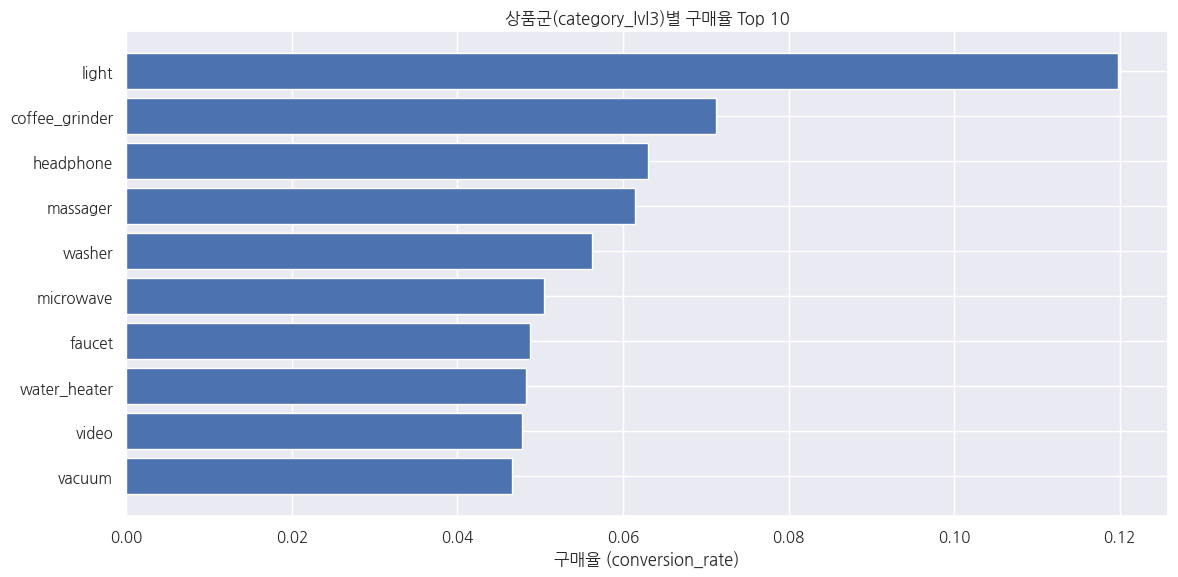

In [24]:
plt.figure(figsize=(12, 6))
plt.barh(category_stats['category_lvl3'], category_stats['conversion_rate'])
plt.xlabel('구매율 (conversion_rate)')
plt.title('상품군(category_lvl3)별 구매율 Top 10')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

가격 구간별 구매율

In [25]:
# 1. 가격 구간 나누기 (10만원 단위, 필요시 조정 가능)
# 올바른 bins와 labels 정의
bins = [0, 100, 200, 300, 400, 500, 1000, float('inf')]  # 8개 → 7개 구간
labels = ['0~100', '100~200', '200~300', '300~400', '400~500', '500~1000', '1000+']  # 7개

# 가격 구간 생성
df['price_bin'] = pd.cut(df['price'], bins=bins, labels=labels, right=False)


# 2. 구매, 조회 이벤트만 나누기
purchase_df = df[df['event_type'] == 'purchase']
view_df = df[df['event_type'] == 'view']

# 3. 가격 구간별 이벤트 수 집계
purchase_stats = purchase_df['price_bin'].value_counts().sort_index().reset_index()
purchase_stats.columns = ['price_bin', 'purchase_count']

view_stats = view_df['price_bin'].value_counts().sort_index().reset_index()
view_stats.columns = ['price_bin', 'view_count']

# 4. 병합 및 구매율 계산
price_group_stats = pd.merge(purchase_stats, view_stats, on='price_bin', how='outer')

# 숫자 컬럼만 골라서 NaN을 0으로 대체
numeric_cols = ['purchase_count', 'view_count']
price_group_stats[numeric_cols] = price_group_stats[numeric_cols].fillna(0)

# 구매율 계산
price_group_stats['conversion_rate'] = price_group_stats['purchase_count'] / price_group_stats['view_count']

# 결과 확인
print(price_group_stats)

  price_bin  purchase_count  view_count  conversion_rate
0     0~100          402950     9157180         0.044004
1   100~200          986327    11177389         0.088243
2   200~300          610408     7245904         0.084242
3   300~400          268533     3922403         0.068461
4   400~500          204417     2651407         0.077098
5  500~1000          640843     7276868         0.088066
6     1000+          246056     2975554         0.082693


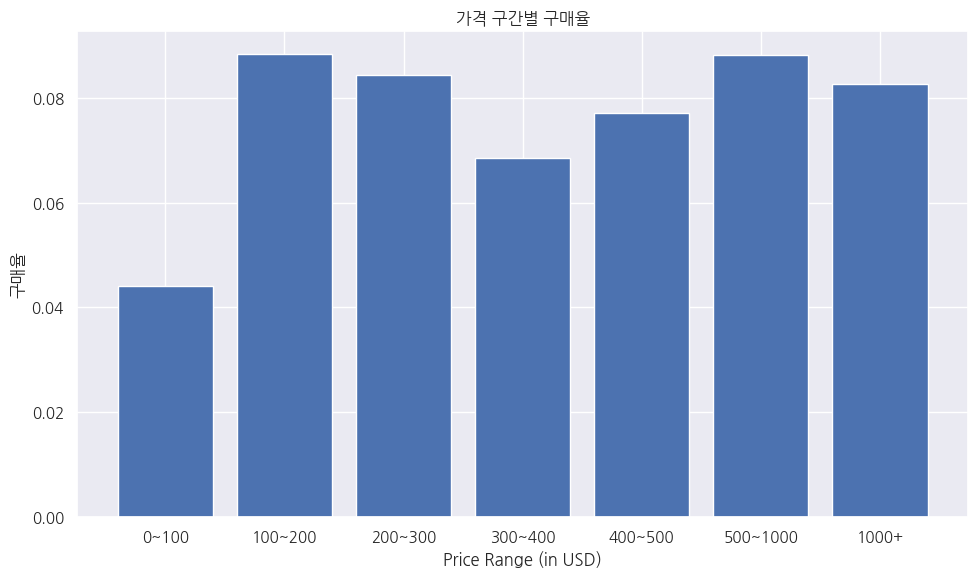

In [26]:
plt.figure(figsize=(10, 6))
plt.bar(price_group_stats['price_bin'].astype(str), price_group_stats['conversion_rate'])
plt.title('가격 구간별 구매율')
plt.xlabel('Price Range (in USD)')
plt.ylabel('구매율')
plt.tight_layout()
plt.show()

전환율

In [27]:
# 1. 이벤트별 필터링
views = df[df['event_type'] == 'view']
carts = df[df['event_type'] == 'cart']
purchases = df[df['event_type'] == 'purchase']

# 2. 상품별 이벤트 수 집계
view_counts = views.groupby('product_id').size().reset_index(name='view_count')
cart_counts = carts.groupby('product_id').size().reset_index(name='cart_count')
purchase_counts = purchases.groupby('product_id').size().reset_index(name='purchase_count')

# 3. 병합
product_stats = view_counts.merge(cart_counts, on='product_id', how='outer')
product_stats = product_stats.merge(purchase_counts, on='product_id', how='outer')
product_stats.fillna(0, inplace=True)

# 4. 퍼널 전환율 계산
product_stats['view_to_cart_rate'] = product_stats['cart_count'] / product_stats['view_count']
product_stats['cart_to_purchase_rate'] = product_stats['purchase_count'] / product_stats['cart_count']
product_stats['view_to_purchase_rate'] = product_stats['purchase_count'] / product_stats['view_count']

# 5. 상품 정보 결합 (선택)
product_stats = pd.merge(
    product_stats,
    df[['product_id', 'category_lvl1', 'category_lvl2', 'category_lvl3']].drop_duplicates(),
    on='product_id', how='left'
)

# 6. 결과 확인 (view 수 기준으로 필터링하여 너무 적은 데이터 제거 가능)
product_stats_filtered = product_stats[product_stats['view_count'] >= 30]
print(product_stats_filtered[['product_id', 'category_lvl3', 'view_to_cart_rate', 'cart_to_purchase_rate', 'view_to_purchase_rate']].sort_values(by='view_to_purchase_rate', ascending=False).head(10))

       product_id    category_lvl3  view_to_cart_rate  cart_to_purchase_rate  \
56853    24601808             pump           0.571429               0.714286   
60439    26203808           faucet           0.212121               1.428571   
44867    20200030           kettle           0.284753               1.047244   
23743     6701232       air_heater           0.241758               1.227273   
14381     4200774  air_conditioner           0.628571               0.454545   
56089    24600504          welding           0.388889               0.714286   
3592      1701206         massager           0.340659               0.806452   
14833     4201541  air_conditioner           0.299394               0.902834   
45033    21100410             pump           0.261905               1.000000   
10299     2800681    refrigerators           0.290323               0.888889   

       view_to_purchase_rate  
56853               0.408163  
60439               0.303030  
44867               0.2982

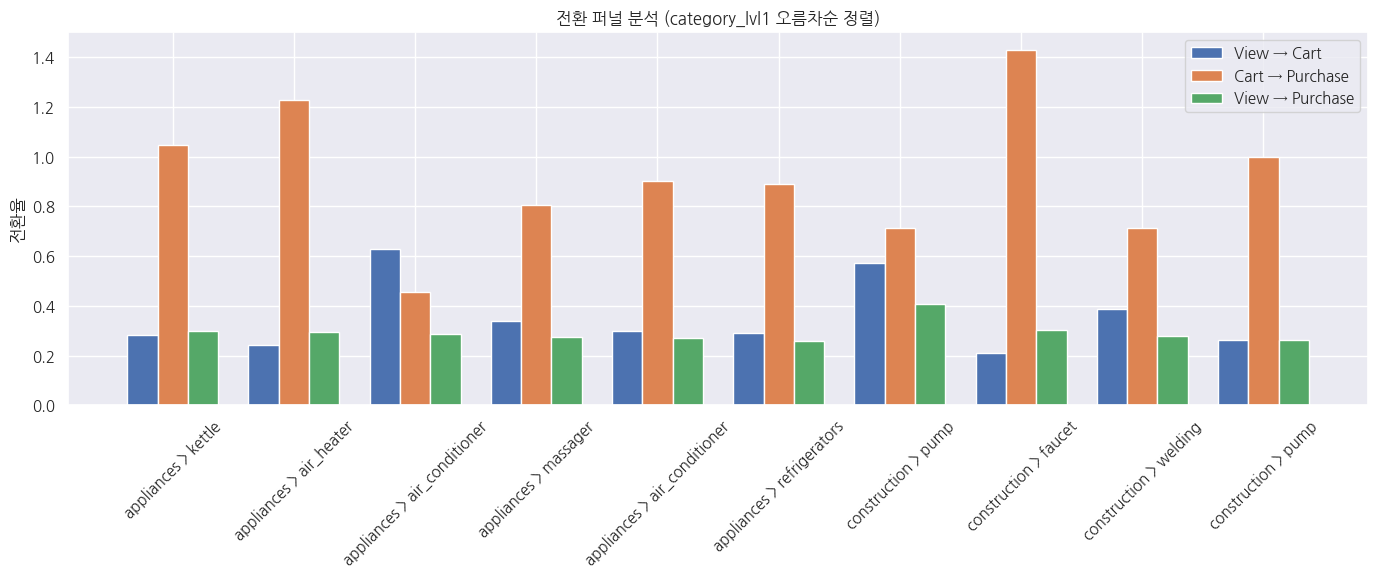

In [31]:
top_funnel = product_stats_filtered.sort_values(by='view_to_purchase_rate', ascending=False).head(10)

# 1. 새로운 라벨 컬럼 생성
top_funnel['category_label'] = top_funnel['category_lvl1'] + ' > ' + top_funnel['category_lvl3']

# 2. category_lvl1 기준 오름차순 정렬
top_funnel_sorted = top_funnel.sort_values(by='category_lvl1')

# 3. 시각화
plt.figure(figsize=(14, 6))
bar_width = 0.25
x = range(len(top_funnel_sorted))

plt.bar(x, top_funnel_sorted['view_to_cart_rate'], width=bar_width, label='View → Cart')
plt.bar([p + bar_width for p in x], top_funnel_sorted['cart_to_purchase_rate'], width=bar_width, label='Cart → Purchase')
plt.bar([p + bar_width*2 for p in x], top_funnel_sorted['view_to_purchase_rate'], width=bar_width, label='View → Purchase')

# 정렬된 라벨 적용
plt.xticks([p + bar_width for p in x], top_funnel_sorted['category_label'], rotation=45)
plt.ylabel('전환율')
plt.title('전환 퍼널 분석 (category_lvl1 오름차순 정렬)')
plt.legend()
plt.tight_layout()
plt.show()

매출 총합

In [29]:
# 1. 상품별 매출 계산 (price × 건수)
product_revenue = purchase_df.groupby('product_id')['price'].sum().reset_index(name='total_revenue')

# 2. 상품 정보 붙이기 (카테고리 포함)
product_info = df[['product_id', 'category_lvl1', 'category_lvl2', 'category_lvl3']].drop_duplicates()
product_revenue = pd.merge(product_revenue, product_info, on='product_id', how='left')

# 3. 매출 총합 상위 10개 상품 출력
top_products = product_revenue.sort_values(by='total_revenue', ascending=False).head(10)
print(top_products)

      product_id  total_revenue category_lvl1 category_lvl2 category_lvl3
1667     1005115   1.160029e+08   electronics    smartphone          None
1668     1005115   1.160029e+08  construction         tools         light
1647     1005105   6.972752e+07   electronics    smartphone          None
1648     1005105   6.972752e+07  construction         tools         light
1707     1005135   3.852481e+07   electronics    smartphone          None
1708     1005135   3.852481e+07  construction         tools         light
67       1002544   3.794599e+07   electronics    smartphone          None
68       1002544   3.794599e+07  construction         tools         light
731      1004249   3.767327e+07  construction         tools         light
730      1004249   3.767327e+07   electronics    smartphone          None


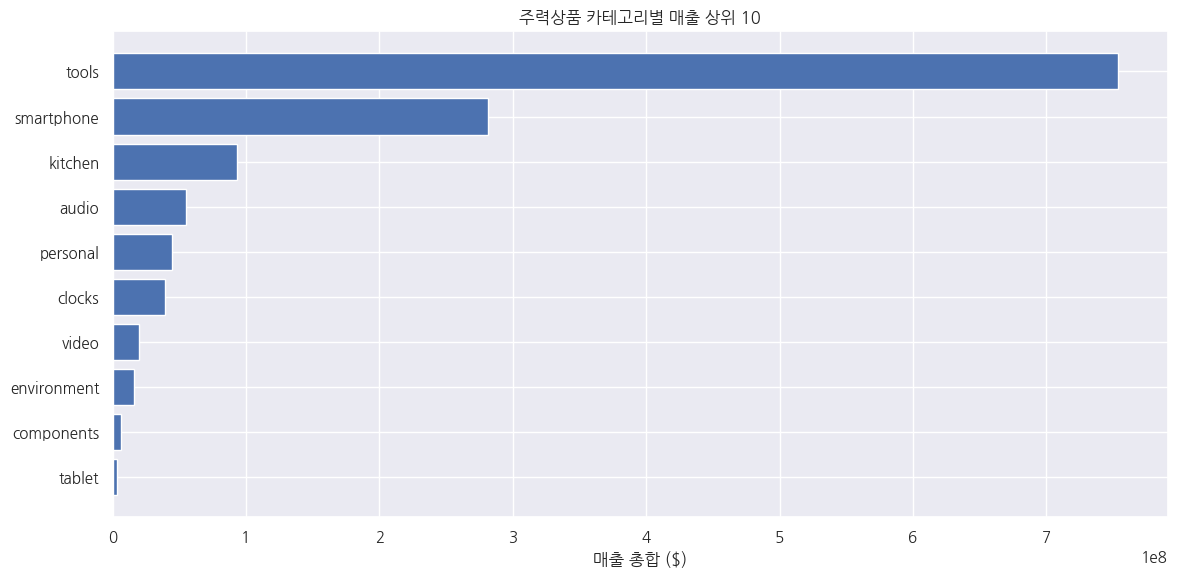

In [30]:
# 4. 카테고리별 매출 총합 (category_lvl2 기준)
category_revenue = purchase_df.groupby('category_lvl2')['price'].sum().reset_index(name='total_revenue')
category_revenue = category_revenue.sort_values(by='total_revenue', ascending=False).head(10)

# 5. 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.barh(category_revenue['category_lvl2'], category_revenue['total_revenue'])
plt.xlabel('매출 총합 ($)')
plt.title('주력상품 카테고리별 매출 상위 10')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

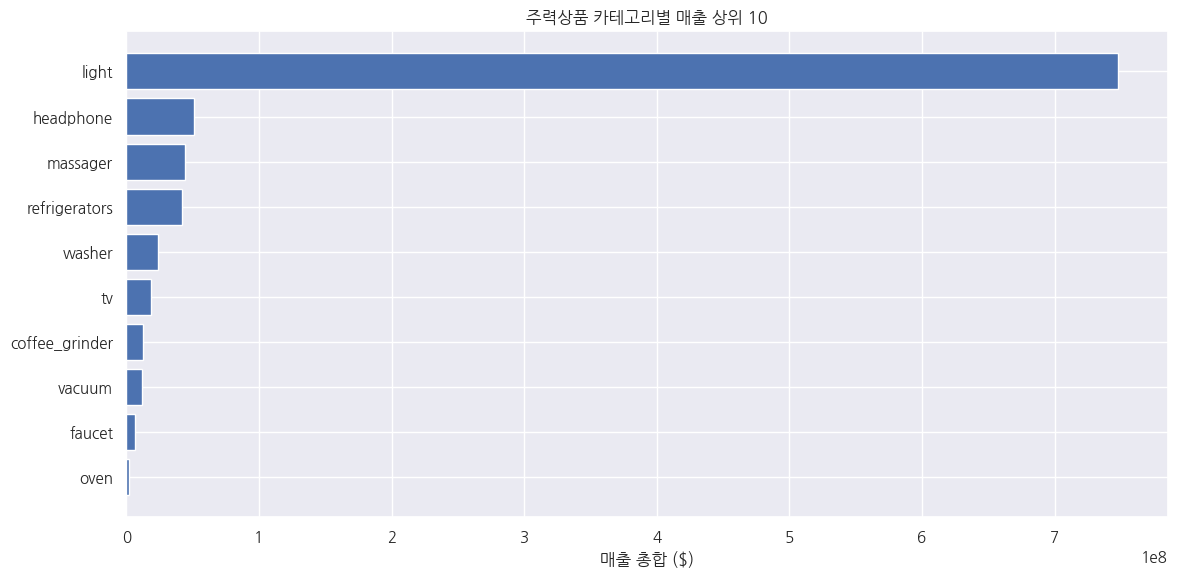

In [32]:
# 4. 카테고리별 매출 총합 (category_lvl3 기준)
category_revenue = purchase_df.groupby('category_lvl3')['price'].sum().reset_index(name='total_revenue')
category_revenue = category_revenue.sort_values(by='total_revenue', ascending=False).head(10)

# 5. 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.barh(category_revenue['category_lvl3'], category_revenue['total_revenue'])
plt.xlabel('매출 총합 ($)')
plt.title('주력상품 카테고리별 매출 상위 10')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

 카테고리별 재구매율 + 매출 기여도 분석

In [33]:
# 구매 이벤트만 필터링
purchase_df = df[df['event_type'] == 'purchase']

# 1. 유저별로 카테고리 구매 횟수 집계
user_cat = purchase_df.groupby(['user_id', 'category_lvl3']).size().reset_index(name='purchase_count')

# 2. 재구매한 유저 수 카운트 (2회 이상)
repurchase_users = user_cat[user_cat['purchase_count'] >= 2].groupby('category_lvl3')['user_id'].nunique().reset_index(name='repurchase_user_count')

# 3. 전체 구매 유저 수
total_users = user_cat.groupby('category_lvl3')['user_id'].nunique().reset_index(name='total_user_count')

# 4. 재구매율 계산
repurchase_rate_df = pd.merge(repurchase_users, total_users, on='category_lvl3')
repurchase_rate_df['repurchase_rate'] = repurchase_rate_df['repurchase_user_count'] / repurchase_rate_df['total_user_count']

# 5. 매출 총합 집계
revenue_df = purchase_df.groupby('category_lvl3')['price'].sum().reset_index(name='total_revenue')

# 6. 병합
final_df = pd.merge(repurchase_rate_df, revenue_df, on='category_lvl3')

# 7. 재구매율 기준 정렬
final_df = final_df.sort_values(by='repurchase_rate', ascending=False)

# 결과 확인
print(final_df.head(10))


      category_lvl3  repurchase_user_count  total_user_count  repurchase_rate  \
21            light                 307449            389677         0.788984   
11           faucet                   7397             14797         0.499899   
22         massager                  26009             52683         0.493689   
6    coffee_grinder                   7480             15431         0.484739   
16        headphone                  29298             60663         0.482963   
39        subwoofer                   4526              9539         0.474473   
44           washer                  17324             37101         0.466942   
1   air_conditioner                   1009              2356         0.428268   
31        projector                   1065              2530         0.420949   
33    refrigerators                  18909             44928         0.420873   

    total_revenue  
21   7.481227e+08  
11   6.247607e+06  
22   4.441232e+07  
6    1.285233e+07  
16   5.1

브랜드별 매출 순위 분석

In [34]:
# 1. 브랜드별 구매 데이터 필터링
brand_revenue = purchase_df.groupby('brand')['price'].sum().reset_index(name='total_revenue')

# 2. 구매 수 기준도 함께 보기 (optional)
brand_count = purchase_df['brand'].value_counts().reset_index()
brand_count.columns = ['brand', 'purchase_count']

# 3. 병합
brand_stats = pd.merge(brand_revenue, brand_count, on='brand')
brand_stats = brand_stats.sort_values(by='total_revenue', ascending=False)

# 결과 상위 10개 확인
print(brand_stats.head(10))

        brand  total_revenue  purchase_count
98      apple   7.193057e+08          882934
1392  samsung   3.050178e+08         1085651
1741   xiaomi   5.956742e+07          297641
750    huawei   2.864091e+07          152416
945        lg   2.349192e+07           51590
1186     oppo   1.752573e+07           77808
3        acer   1.374678e+07           27364
972   lucente   1.308691e+07           40716
938    lenovo   9.044502e+06           24444
130      asus   6.738587e+06           13130


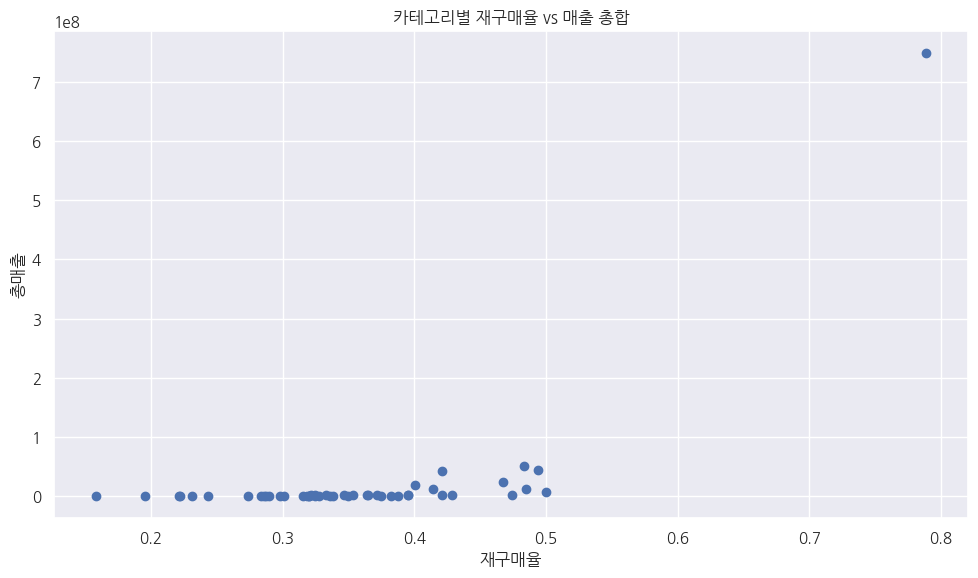

In [35]:
# 시각화: 재구매율 + 매출
plt.figure(figsize=(10,6))
plt.scatter(final_df['repurchase_rate'], final_df['total_revenue'])
plt.xlabel('재구매율')
plt.ylabel('총매출')
plt.title('카테고리별 재구매율 vs 매출 총합')
plt.grid(True)
plt.tight_layout()
plt.show()

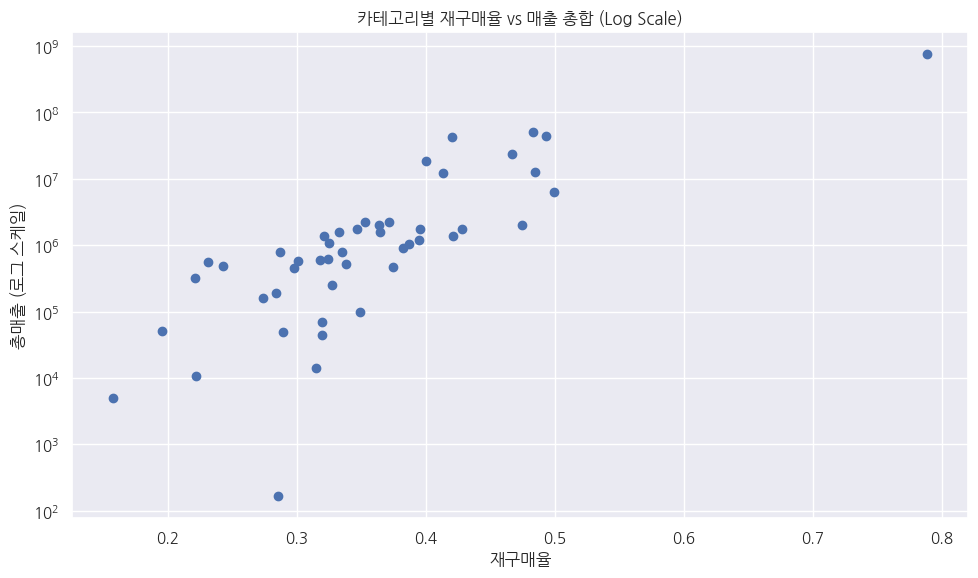

In [37]:
plt.figure(figsize=(10, 6))
plt.scatter(final_df['repurchase_rate'], final_df['total_revenue'])
plt.yscale('log')  # 로그 스케일 적용
plt.xlabel('재구매율')
plt.ylabel('총매출 (로그 스케일)')
plt.title('카테고리별 재구매율 vs 매출 총합 (Log Scale)')
plt.grid(True)
plt.tight_layout()
plt.show()


# 4. 주력상품 집중 분석
재구매 고객 수 vs 재구매 간격 vs 고객 수익성 비교

 1. 재구매 고객 수

In [43]:
purchase_df = df[df['event_type'] == 'purchase']
repeat_customers = purchase_df.groupby('category_lvl3')['user_id'].nunique().reset_index()
repeat_customers.columns = ['category_lvl3', 'repeat_customer_count']


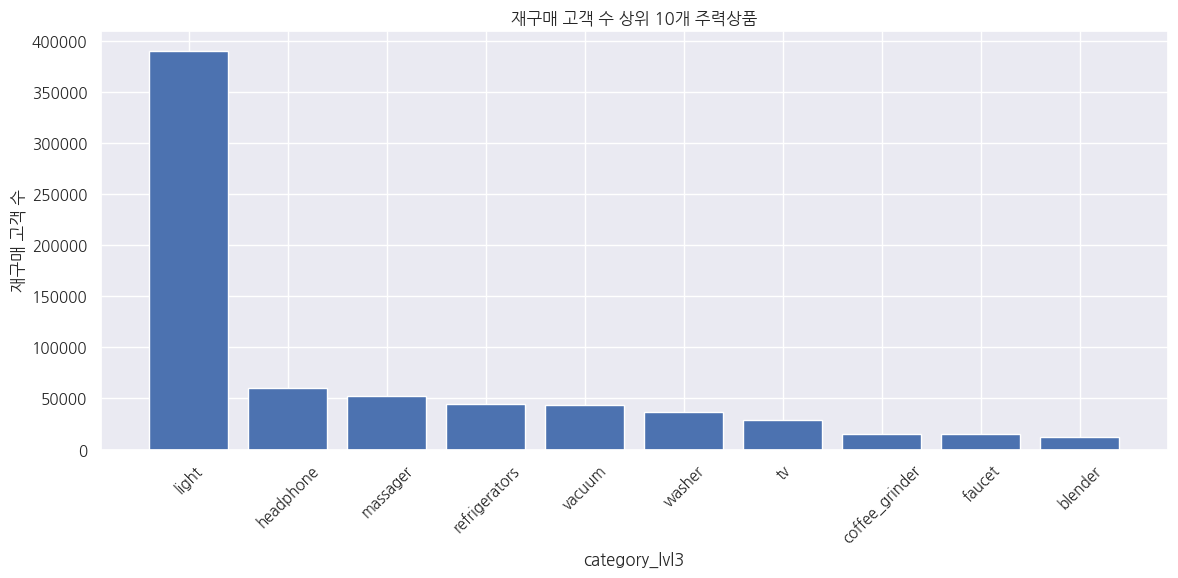

In [44]:
top_repeat = repeat_customers.sort_values(by='repeat_customer_count', ascending=False).head(10)
plt.figure(figsize=(12, 6))
plt.bar(top_repeat['category_lvl3'].astype(str), top_repeat['repeat_customer_count'])
plt.title('재구매 고객 수 상위 10개 주력상품')
plt.xlabel('category_lvl3')
plt.ylabel('재구매 고객 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


2. 재구매 간격

In [50]:
# 1. 날짜 변환
df['event_date'] = pd.to_datetime(df['event_date'])

# 2. 구매 이벤트 필터링
purchase_df = df[df['event_type'] == 'purchase'].copy()

# 3. 구매 이력 정렬 및 간격 계산
purchase_sorted = purchase_df.sort_values(by=['user_id', 'product_id', 'event_date'])
purchase_sorted['days_diff'] = purchase_sorted.groupby(['user_id', 'product_id'])['event_date'].diff().dt.days

# 4. 상품 기준 평균 재구매 간격
product_days = purchase_sorted.groupby('product_id')['days_diff'].mean().reset_index()
product_days.columns = ['product_id', 'avg_repurchase_gap']

# 5. 카테고리 기준 재구매 간격 계산
repeat_df = purchase_sorted[purchase_sorted['days_diff'].notnull()]  # 재구매가 일어난 경우만
category_repeat_interval = repeat_df.groupby('category_lvl3')['days_diff'].mean().reset_index()
category_repeat_interval.columns = ['category_lvl3', 'avg_days_between_purchase']

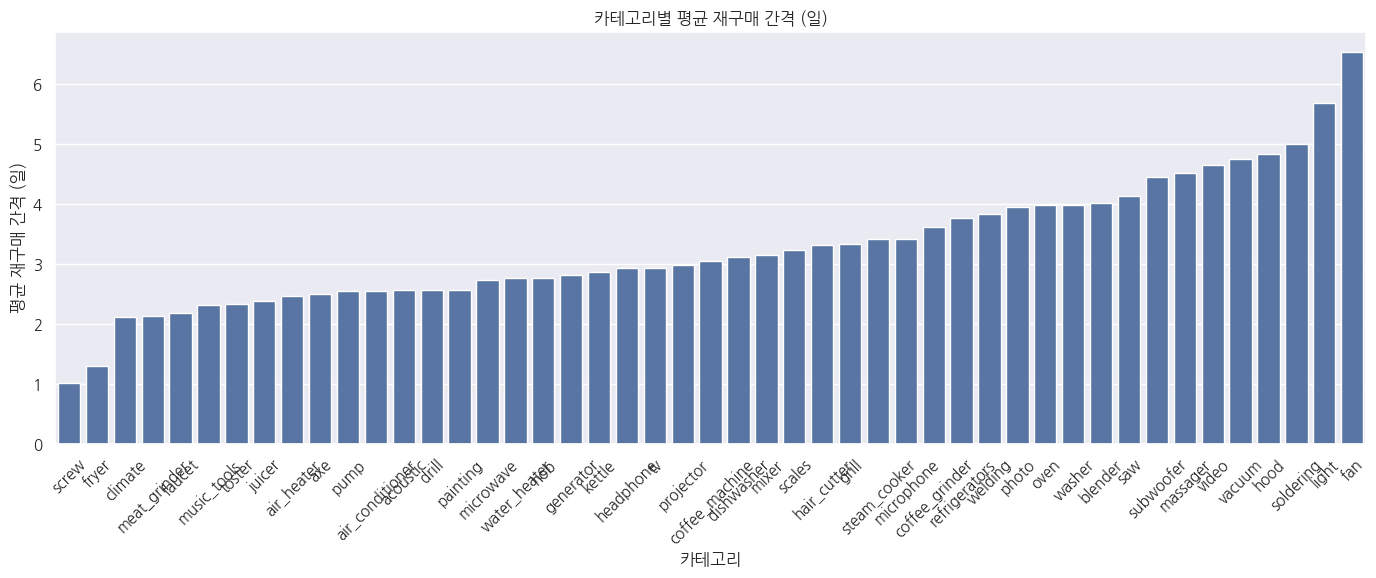

In [51]:
# 6. 시각화
plt.figure(figsize=(14, 6))
sns.barplot(data=category_repeat_interval.sort_values('avg_days_between_purchase'),
            x='category_lvl3', y='avg_days_between_purchase')
plt.xticks(rotation=45)
plt.title('카테고리별 평균 재구매 간격 (일)')
plt.xlabel('카테고리')
plt.ylabel('평균 재구매 간격 (일)')
plt.tight_layout()
plt.show()

3. 고객 수익성

In [52]:
# 유저별 전체 구매금액
user_value = purchase_df.groupby('user_id')['price'].sum().reset_index()
user_value.columns = ['user_id', 'total_spent']

# 카테고리별 평균 고객 구매금액 계산
avg_value_cat = purchase_df.groupby('category_lvl3')['user_id'].apply(
    lambda x: user_value[user_value['user_id'].isin(x)]['total_spent'].mean()
).reset_index(name='avg_user_value')

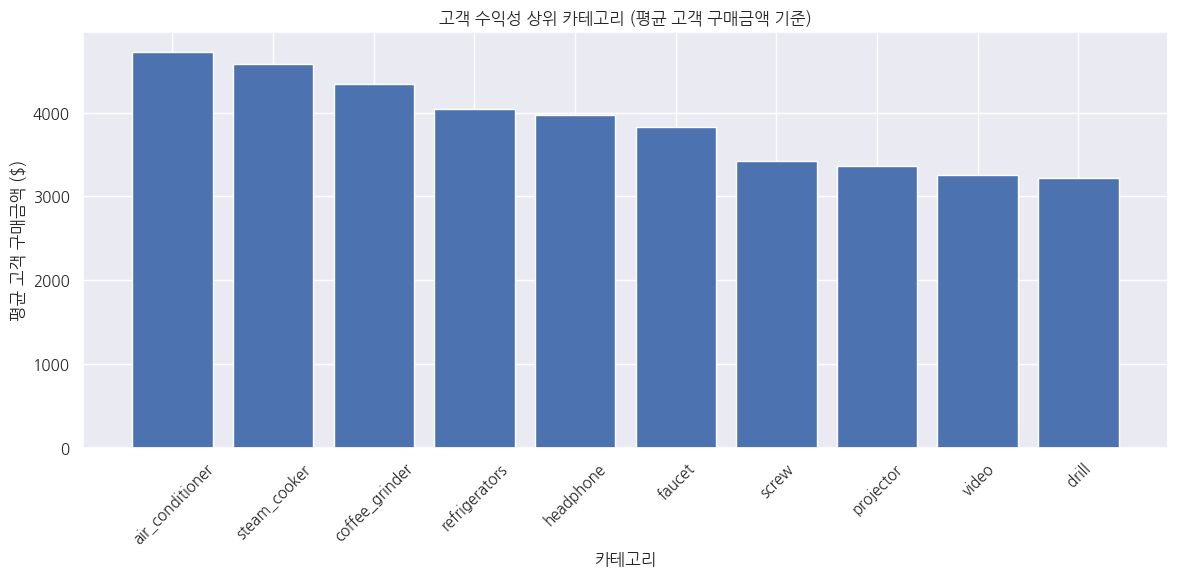

In [54]:
# 상위 카테고리 10개 시각화
top_value_cat = avg_value_cat.sort_values('avg_user_value', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(top_value_cat['category_lvl3'].astype(str), top_value_cat['avg_user_value'])
plt.title('고객 수익성 상위 카테고리 (평균 고객 구매금액 기준)')
plt.xlabel('카테고리')
plt.ylabel('평균 고객 구매금액 ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 월별 구매 트렌드

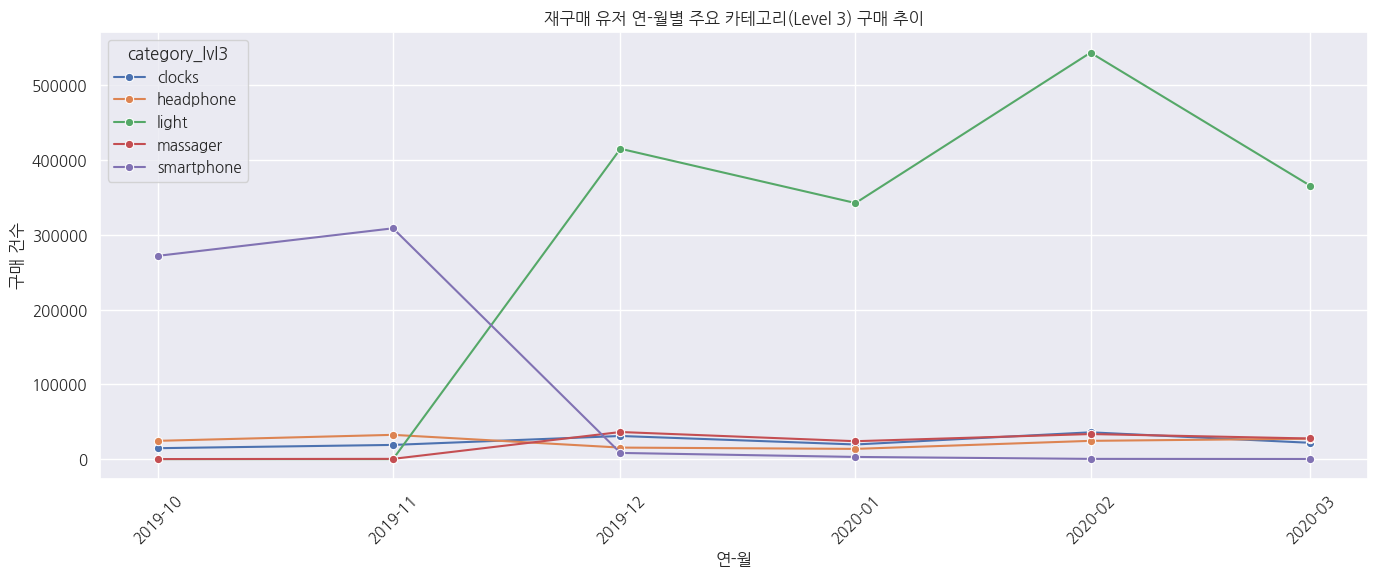

In [63]:
# event_date에서 연-월만 추출
monthly_top = (
    purchase_df.groupby([purchase_df['event_date'].dt.to_period('M'), 'category_lvl3'])['product_id']
    .count()
    .reset_index(name='purchase_count')
)

# 다시 datetime으로 변환해 시계열 정렬
monthly_top['event_date'] = monthly_top['event_date'].dt.to_timestamp()

# 전체 기간 동안 가장 많이 팔린 top 5 카테고리 추출
top_cats = (
    monthly_top.groupby('category_lvl3')['purchase_count']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

# top 카테고리만 필터링
monthly_top = monthly_top[monthly_top['category_lvl3'].isin(top_cats)]

# 시각화
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_top, x='event_date', y='purchase_count', hue='category_lvl3', marker='o')
plt.title('재구매 유저 연-월별 주요 카테고리(Level 3) 구매 추이')
plt.xlabel('연-월')
plt.ylabel('구매 건수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


재구매율이 높은 제품군의 공통된 특성을 정성/정량적으로 파악

In [74]:
# 유저 수 대비 재구매한 유저 비율 계산
total_users_per_cat = df[df['event_type'] == 'purchase'].groupby('category_lvl3')['user_id'].nunique()
repeat_users_per_cat = repeat_df.groupby('category_lvl3')['user_id'].nunique()
repurchase_rate = (repeat_users_per_cat / total_users_per_cat).reset_index(name='repurchase_rate')


In [75]:
top_repeat = repurchase_rate.sort_values('repurchase_rate', ascending=False).head(10)


In [76]:
# 각 카테고리별 평균 재구매 간격 및 가격
repeat_df['event_date'] = pd.to_datetime(repeat_df['event_date'])
sorted_df = repeat_df.sort_values(['user_id', 'category_lvl3', 'event_date'])
sorted_df['days_diff'] = sorted_df.groupby(['user_id', 'category_lvl3'])['event_date'].diff().dt.days

avg_gap = sorted_df.groupby('category_lvl3')['days_diff'].mean().reset_index(name='avg_gap')
avg_price = repeat_df.groupby('category_lvl3')['price'].mean().reset_index(name='avg_price')

# 통합
repeat_features = top_repeat.merge(avg_gap, on='category_lvl3').merge(avg_price, on='category_lvl3')

# 카테고리 레벨2, 레벨1 정보 병합
category_mapping = repeat_df[['category_lvl3', 'category_lvl2', 'category_lvl1']].drop_duplicates()
repeat_features = repeat_features.merge(category_mapping, on='category_lvl3', how='left')

repeat_features

,category_lvl3,repurchase_rate,avg_gap,avg_price,category_lvl2,category_lvl1
0,light,0.581299,3.455660,464.950542,tools,construction
1,massager,0.357440,3.412765,376.410259,personal,appliances
2,headphone,0.351466,3.196485,385.474234,audio,electronics
3,washer,0.323576,3.947901,297.260598,kitchen,appliances
4,coffee_grinder,0.317219,3.875255,356.672306,kitchen,appliances
5,faucet,0.314456,2.968545,169.225294,components,construction
6,projector,0.305534,3.340681,278.161660,video,electronics
7,air_conditioner,0.303905,2.142127,465.404717,environment,appliances
8,subwoofer,0.303805,4.176471,102.238958,audio,electronics
9,refrigerators,0.301838,3.321884,496.616876,kitchen,appliances


| category\_lvl3       | repurchase\_rate | avg\_gap | avg\_price | 특성 분류        | 근거 요약                      |
| -------------------- | ---------------- | -------- | ---------- | ------------ | -------------------------- |
| **light**            | 0.58             | 3.46     | 465.95     | 생활 밀접 or 공구류 | 자주 교체 또는 여러 장소 설치 가능성      |
| **massager**         | 0.36             | 3.41     | 376.41     | 생활 밀접        | 사용 후 반복 구매 가능성 (가정용 헬스/웰빙) |
| **headphone**        | 0.35             | 3.20     | 385.47     | 생활 밀접/소모성    | 분실·고장 잦음, 가정/사무/야외 다수 구매   |
| **washer**           | 0.32             | 3.95     | 297.26     | 고관여 가전       | 품질별 구분 구매 or 반복 구매자 존재 가능성 |
| **coffee\_grinder**  | 0.32             | 3.87     | 356.67     | 반복 소모품       | 커피 소비 습관 관련, 분쇄기 교체/보완 구매  |
| **faucet**           | 0.31             | 2.97     | 169.23     | 수리·공사 부품     | 교체 수요 높고 설치 단위로 반복 구매 가능   |
| **projector**        | 0.31             | 3.34     | 278.16     | 시즌성 or 특수 목적 | 교육/행사/홈시네마용 등 정기적 수요 가능성   |
| **air\_conditioner** | 0.30             | 2.14     | 465.40     | 시즌성 가전       | 여름철 중심 수요, 복수 구비 가능성       |
| **subwoofer**        | 0.30             | 4.18     | 102.24     | 취미형 소모품      | 음악·홈시어터 관련 소비 (복수 시스템 구축)  |
| **refrigerators**    | 0.30             | 3.32     | 496.62     | 생활 밀접 가전     | 세컨드 냉장고 수요 or 상업용 반복 구매 가능 |


In [77]:
# 1. 사용자별 상품 재구매 간격 계산
df['event_date'] = pd.to_datetime(df['event_date'])
purchase_df = df[df['event_type'] == 'purchase']

purchase_sorted = purchase_df.sort_values(by=['user_id', 'category_lvl2', 'event_date'])
purchase_sorted['days_diff'] = purchase_sorted.groupby(['user_id', 'category_lvl2'])['event_date'].diff().dt.days

# 2. category_lvl2 기준 재구매 간격과 구매율 계산
repeat_metrics = purchase_sorted.dropna(subset=['days_diff']).groupby('category_lvl2').agg(
    repurchase_rate=('user_id', lambda x: x.nunique() / purchase_df['user_id'].nunique()),
    avg_gap=('days_diff', 'mean'),
    avg_price=('price', 'mean')
).reset_index()

# 3. category_lvl1 정보 붙이기
lvl2_to_lvl1 = df[['category_lvl2', 'category_lvl1']].drop_duplicates()
repeat_metrics = repeat_metrics.merge(lvl2_to_lvl1, on='category_lvl2', how='left')

# 4. 정렬 및 상위 N개 확인
repeat_metrics = repeat_metrics.sort_values(by='repurchase_rate', ascending=False)
top_repeat_metrics = repeat_metrics.head(10)

top_repeat_metrics


,category_lvl2,repurchase_rate,avg_gap,avg_price,category_lvl1
13,tools,0.493635,4.788465,442.168170,construction
10,smartphone,0.192229,3.649769,479.103320,electronics
7,kitchen,0.116215,8.049630,293.133887,appliances
0,audio,0.057692,6.279084,340.719012,electronics
2,clocks,0.045704,7.025892,293.996058,electronics
8,personal,0.043717,5.098694,355.609204,appliances
4,environment,0.036105,7.686518,170.198850,appliances
14,video,0.019582,4.836093,326.608617,electronics
3,components,0.011465,4.418344,166.391523,construction
1,camera,0.008745,4.749123,60.518961,electronics


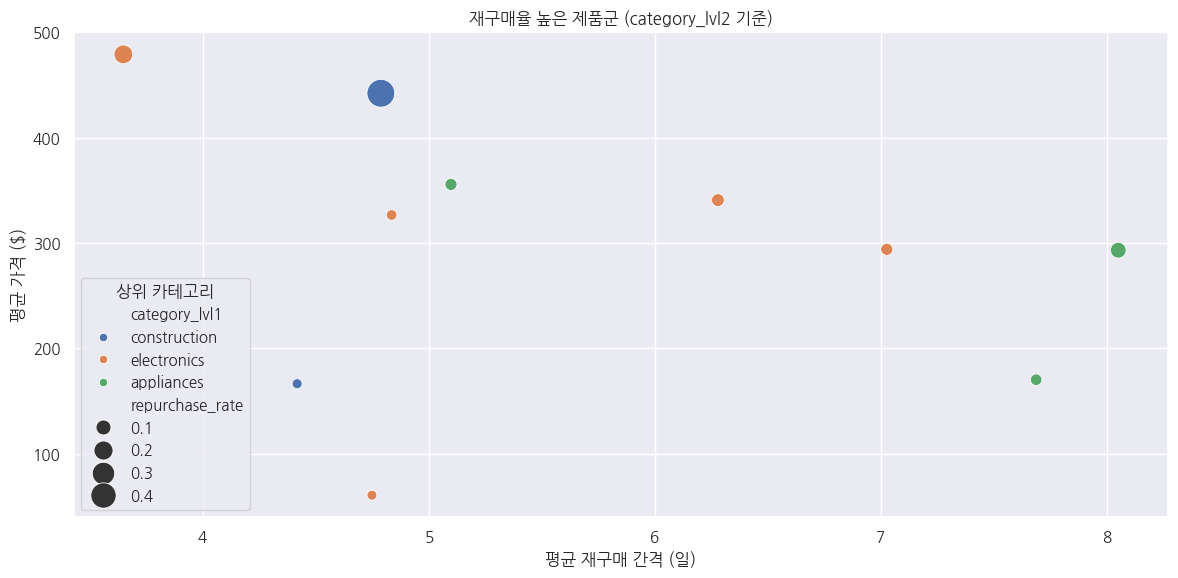

In [70]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=top_repeat_metrics,
    x='avg_gap', y='avg_price',
    hue='category_lvl1', size='repurchase_rate',
    sizes=(50, 400)
)
plt.title('재구매율 높은 제품군 (category_lvl2 기준)')
plt.xlabel('평균 재구매 간격 (일)')
plt.ylabel('평균 가격 ($)')
plt.legend(title='상위 카테고리')
plt.tight_layout()
plt.show()
